In [15]:
from sklearn.dummy import DummyClassifier
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
import sys
import random
import copy
import time
import shutil
import pickle
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from pandas import DataFrame
import seaborn as sn
import numpy as np
import PIL
from PIL import Image
from math import sqrt
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [16]:
# !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [17]:
from ipynb.fs.full._3_prepare_tracked_datasets import Char,Poly,Point,CustomUnpickler
from ipynb.fs.full._2_emnist_analyze import LeNet,MyResNet,BasicBlock,Trainer

In [18]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [19]:
BATCH_SIZE=50
EPOCHS=10
ACTIVATE="hardswish"
DROPOUT=True
BATCHNORM=True
TRACK_MAX_LEN=3000
CURRENT_FOLDER="./"
DATASET_VARIANT="byclass"
tr=Trainer()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

load dataset

In [20]:
f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict_UJI.p'), 'rb')
f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict_UJI.p'), 'rb')
TRAIN_DICT = CustomUnpickler(f_train_dict).load()
TEST_DICT = CustomUnpickler(f_test_dict).load()
f_train_dict.close()
f_test_dict.close()

In [21]:
# print(TRAIN_DICT)
# print(TEST_DICT)
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print("Классов: {}".format(len(list(TRAIN_DICT.keys()))))
print(list(TRAIN_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
  all_size+=len(TRAIN_DICT[key])

Классов: 62
None


In [22]:
all_size,TRAIN_DICT.keys()

(5913,
 dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'P', 'Q', 'S', 'T', 'U', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'i', 'j', 'o', 'N', 'O', 'R', 'V']))

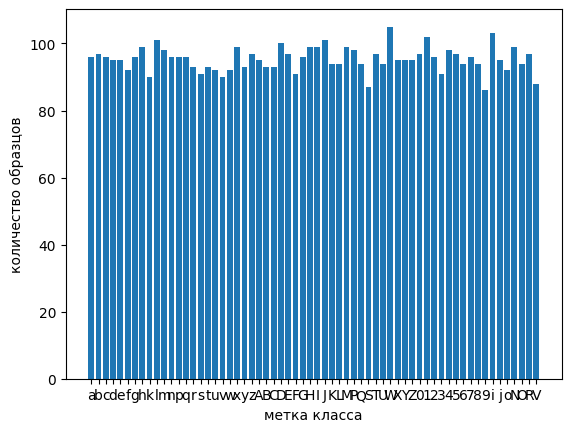

In [23]:
if __name__ == "__main__":
    plt.bar( TRAIN_DICT.keys(),[len(TRAIN_DICT[key]) for key in TRAIN_DICT.keys()])
    plt.xlabel("метка класса")
    plt.ylabel("количество образцов")
    # plt.savefig("images/uji_dataset.png",  bbox_inches='tight', pad_inches=0)

Single track length max:6705.0; min:244.0; avg:1566.2812447150347
Single track length>3000: 128


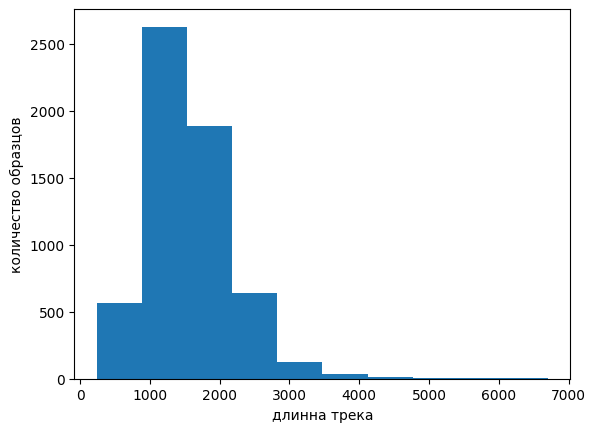

In [24]:
if __name__ == "__main__":
    data=TRAIN_DICT
    rez=np.array([])
    for key in data.keys():
        for ch in data[key]:
            rez=np.append(rez,len(ch.singlePolys().angles))
    print("Single track length max:{}; min:{}; avg:{}".format(max(rez),min(rez),sum(rez)/len(rez)))  
    print("Single track length>{}: {}".format(TRACK_MAX_LEN,sum(rez>TRACK_MAX_LEN)))
    plt.hist(rez)
    plt.xlabel("длинна трека")
    plt.ylabel("количество образцов")
    plt.savefig("images/uji_tracks_disp.png",  bbox_inches='tight', pad_inches=0)

1553


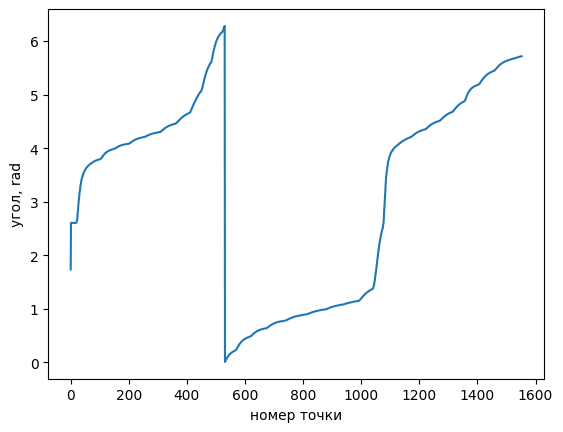

In [25]:
if __name__ == "__main__":
    data=TRAIN_DICT['a'][0].singlePolys().angles
    print(len(data))
    plt.plot(range(len(data)),data)
    plt.xlabel("номер точки")
    plt.ylabel("угол, rad")
    plt.savefig("images/a_char_angles_change.png",  bbox_inches='tight', pad_inches=0)

In [9]:
class DynDataset(Dataset):

    def __init__(self, data, transform=None, data_type='fft_angles',track_max_len=TRACK_MAX_LEN):
        str="0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        self.type=data_type
        self.track_max_len=track_max_len
        self.data=np.array([])
        for key in data.keys():
            for ch in data[key]:
                if key in str:
                    self.data=np.append(self.data,[ch])              
        self.classes=list(str)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_ix = np.zeros([self.track_max_len], dtype='float32')
        if self.type=='angles':
            vec=self.data[idx].singlePolys().angles
        elif self.type=='speed':
            vec=self.data[idx].singlePolys().speeds
        elif self.type=='fft_angles':
            vec=self.data[idx].singlePolys().fft_angles
        else:
            vec=self.data[idx].singlePolys().fft_speeds  
        # ограничим длинну трека
        data_ix[:len(vec)] = vec[:self.track_max_len]
        class_num=self.classes.index(self.data[idx].name)
        return torch.Tensor(data_ix),class_num

In [10]:
vec_datasets = {"train": DynDataset(TRAIN_DICT, data_type='angles'),
                 "val":DynDataset(TEST_DICT, data_type='angles')}
dataloaders = {"train": torch.utils.data.DataLoader(vec_datasets["train"], batch_size=BATCH_SIZE,shuffle=True),
               "val": torch.utils.data.DataLoader(vec_datasets["val"], batch_size=BATCH_SIZE,shuffle=True),
}
dataset_sizes = {x: len(vec_datasets[x]) for x in ['train', 'val']}
classes_names = {x: vec_datasets[x].classes for x in ['train', 'val']}

torch.Size([3, 50, 3000])


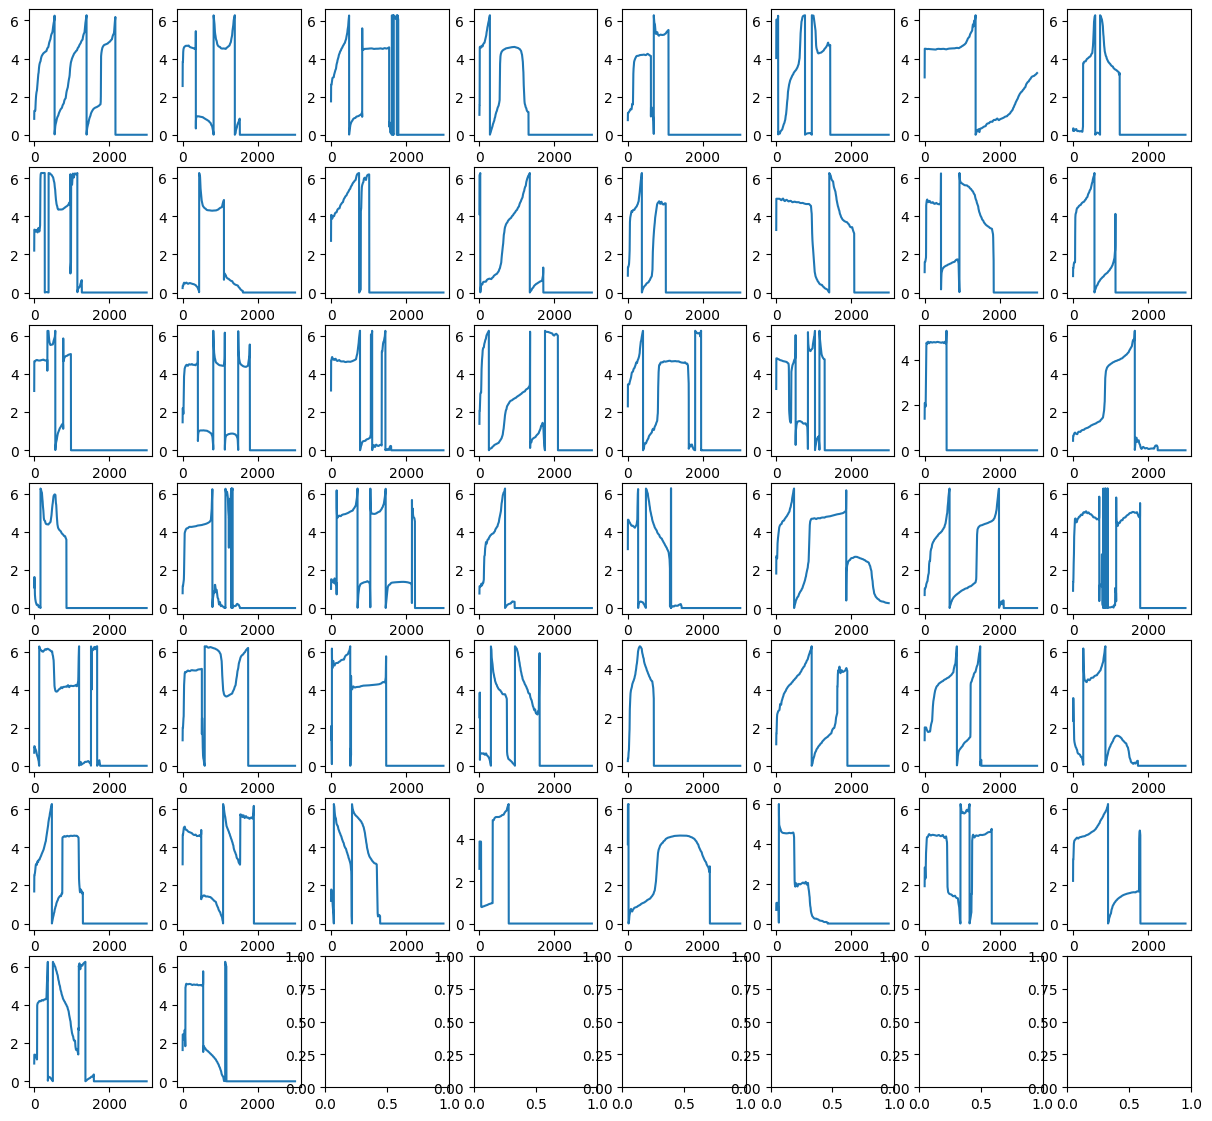

    a     n     q     y     x     9     b     5     7     7     t     e     4     b     D     U     M     m     E     5     q     M     I     t     3     F     W     c     5     y     d     H     z     R     Y     3     s     Q     a     v     9     R     3     x     f     T     H     U     5     r


In [14]:
def imshow(img):
    n=int(sqrt(BATCH_SIZE))+1
    npimg = img.numpy()
    img=npimg[0]
    figure, axis = plt.subplots(n-1, n,figsize=(15, 14))
    count=0
    for j in range(n):
        for i in range(n):
            if count<img.shape[0]:
                axis[j, i].plot(range(TRACK_MAX_LEN),img[count])
            count+=1
    plt.savefig("images/uji_images_angles.png",  bbox_inches='tight', pad_inches=0)      
    plt.show()

if __name__ == "__main__":    
    # Get a batch of training data
    image, label = next(iter(dataloaders['val']))
    out = torchvision.utils.make_grid(image)
    print(out.shape)
    imshow(torchvision.utils.make_grid(out))
    str=' '.join('%5s' % vec_datasets['val'].classes[label[j]] for j in range(BATCH_SIZE))
    print(str)
    with open('images/uji_angles_lbl.txt', 'w') as f:
        f.write(str)

create model

FCNN

In [15]:
class FNNCell(torch.nn.Module):
    def __init__(self,channel=1,track_max_len=TRACK_MAX_LEN,num_classes=len(CHAR_LIST),activate=ACTIVATE):
        super(FNNCell, self).__init__()
        self.SHOW=0
        self.layers=torch.nn.ModuleList()  

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Linear(track_max_len, 256))
        l.append(Trainer.getActivateFunction(activate))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=1))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Linear(256, 100))
        l.append(Trainer.getActivateFunction(activate))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=1))

       
        self.flat = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(100,num_classes)
        
    def forward(self, x):
        x = self._forward(x)      
        x = self.fc1(x)
        return x

    def _forward(self, x):
        n=1 
        x =  x[:,None,:]

        for layer in self.layers:
          for elem in layer:
            x=elem(x)
            if self.SHOW==0: print("--->   {}".format(x.shape))   
          n+=1 
          if self.SHOW==0: print("====")  
        self.SHOW+=1
        # x = self.ga(x)
        x = self.flat(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        return x
    
    def _inference(self, x):
        x = self._forward(x)
        return x    

In [16]:
net=FNNCell(track_max_len=TRACK_MAX_LEN,num_classes=len(vec_datasets["train"].classes)).to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

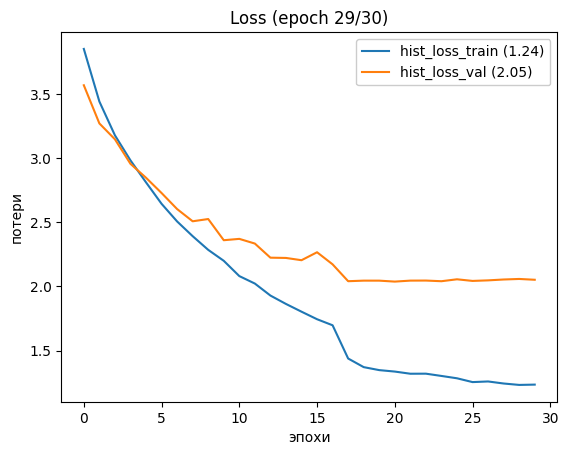

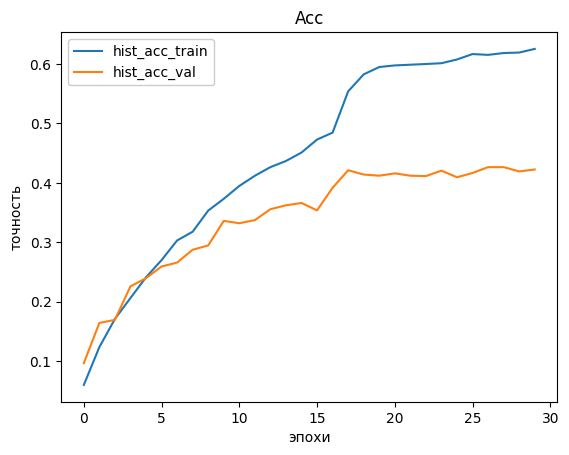

Train time:50.13704705238342
Best acc:0.41584806810740016


In [18]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=30, net_name="FNNCell_uji")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

RNN2

In [19]:
class RNN2Cell(nn.Module):

    def __init__(self, bidirectional=False, track_max_len=TRACK_MAX_LEN,
                 num_classes=len(CHAR_LIST),  rnn_num_units=200):
        super(self.__class__, self).__init__()
        self.track_max_len=track_max_len
        self.num_units = rnn_num_units
        self.num_layers = 1
        self.rnn = nn.RNN(1,
                          self.num_units,
                          num_layers=self.num_layers,
                          batch_first=True,
                          bidirectional=bidirectional,
                          dropout=0.2
                         )
        self.rnn_to_logits = nn.Linear(self.num_units*2 if bidirectional else self.num_units, num_classes)

    def forward(self, x):
        # x = torch.transpose(x,0,1)
        x=x[:,:,None]
        output, _ = self.rnn(x)
        logits = self.rnn_to_logits(output[:,-1,:])
        return logits # только последний элемент в цепочке


In [20]:
net=RNN2Cell(track_max_len=TRACK_MAX_LEN,num_classes=len(vec_datasets["train"].classes)).to(device)

/usr/lib64/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

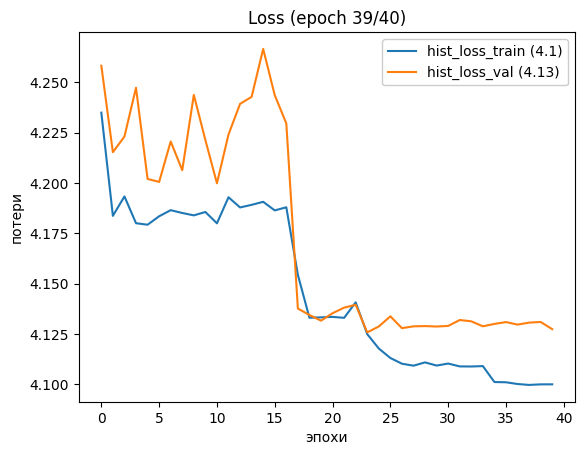

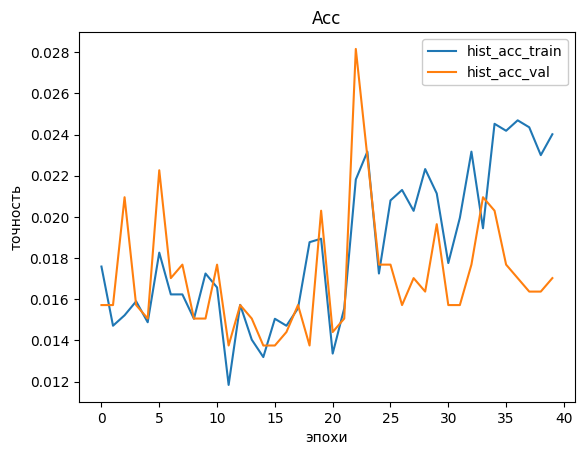

Train time:634.6817805767059
Best acc:0.022920759659463


In [22]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=40, net_name="RNN2Cell_uji")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

LSTM

In [23]:
class LSTMCell(nn.Module):

    def __init__(self, bidirectional=False, track_max_len=TRACK_MAX_LEN,
                 num_classes=len(CHAR_LIST),  rnn_num_units=200):
        super(self.__class__, self).__init__()
        self.track_max_len=track_max_len
        self.num_units = rnn_num_units
        self.num_layers = 1
        self.rnn = nn.LSTM(1,
                          self.num_units,
                          num_layers=self.num_layers,
                          batch_first=True,
                          bidirectional=bidirectional, 
                          dropout=0.2
                          )
        self.rnn_to_logits = nn.Linear(self.num_units*2 if bidirectional else self.num_units, num_classes)

    def forward(self, x):
        x=x[:,:,None]
        output, _ = self.rnn(x)
        logits = self.rnn_to_logits(output[:,-1,:])
        return logits# только последний элемент в цепочке

In [24]:
net=LSTMCell(track_max_len=TRACK_MAX_LEN,num_classes=len(vec_datasets["train"].classes)).to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

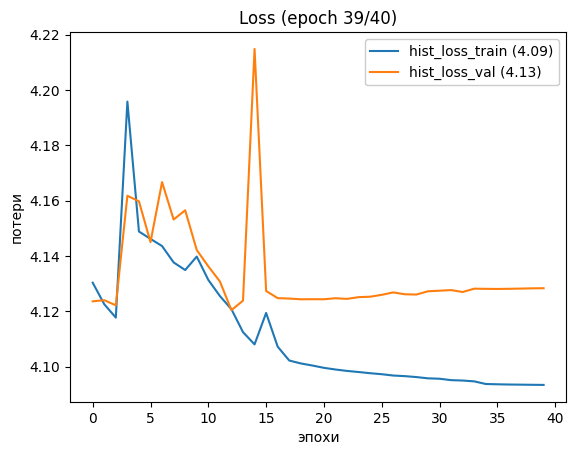

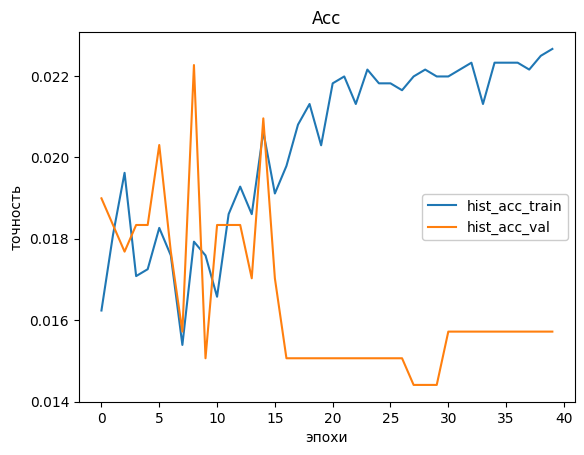

Train time:1598.5088176727295
Best acc:0.0183366077275704


In [26]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=40, net_name="LSTMCell_uji")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

CNN

In [11]:
class CNNCell(torch.nn.Module):
    def __init__(self,channel=1,num_classes=len(CHAR_LIST),activate=ACTIVATE):
        super(CNNCell, self).__init__()
        self.SHOW=0
        self.layers=torch.nn.ModuleList()  

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(1, 20, 3))
        l.append(Trainer.getActivateFunction(activate))
        l.append(torch.nn.MaxPool1d(2))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=20))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(20, 30, 3))
        l.append(Trainer.getActivateFunction(activate))
        l.append(torch.nn.MaxPool1d(2))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=30))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(30, 40, 3))
        l.append(Trainer.getActivateFunction(activate))
        l.append(torch.nn.MaxPool1d(7))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=40))

        self.ga = torch.nn.AdaptiveMaxPool1d(7)
        self.flat = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(7*40,num_classes)

        
    def forward(self, x):
        x = self._forward(x)      
        x = self.fc1(x)
        return x

    def _forward(self, x):
        n=1 
        x =  x[:,None,:]

        for layer in self.layers:
          for elem in layer:
            x=elem(x)
            if self.SHOW==0: print("--->   {}".format(x.shape))   
          n+=1 
          if self.SHOW==0: print("====")  
        self.SHOW+=1
        x = self.ga(x)
        x = self.flat(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        #x = self.sm(x)
        return x
    
    def _inference(self, x):
        x = self._forward(x)
        #x = self.sm(x)
        return x

In [12]:
net=CNNCell(num_classes=len(vec_datasets["train"].classes)).to(device)

train

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

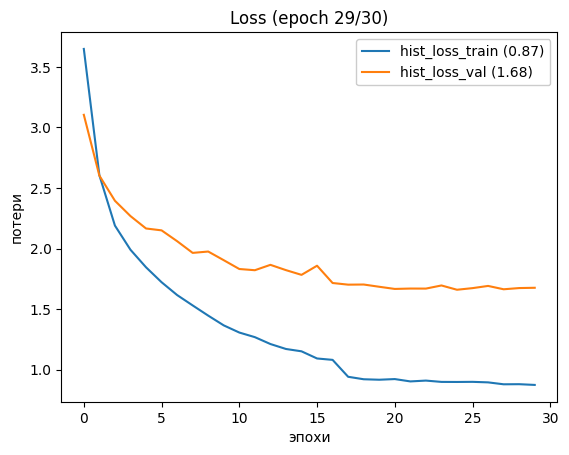

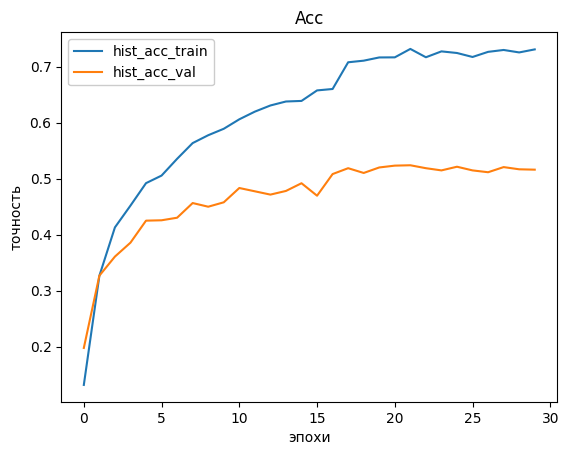

Train time:96.22999095916748
Best acc:0.52128356254093


In [14]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=30, net_name="CNNCell_uji")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

In [14]:
if __name__ == "__main__":
    torch.save(model.state_dict(), "models/uji_angles_cnnnet_"+DATASET_VARIANT+".pt")
    model.load_state_dict(torch.load("models/uji_angles_cnnnet_"+DATASET_VARIANT+".pt"))

<All keys matched successfully>

analyze

In [15]:
if __name__ == "__main__":
    _preds=np.array([])
    _targets=np.array([])
    for inputs, labels in dataloaders['val']:    # Iterate over data.
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        _targets=np.append(_targets, labels.detach().cpu().numpy())
        _preds=np.append(_preds,preds.detach().cpu().numpy())


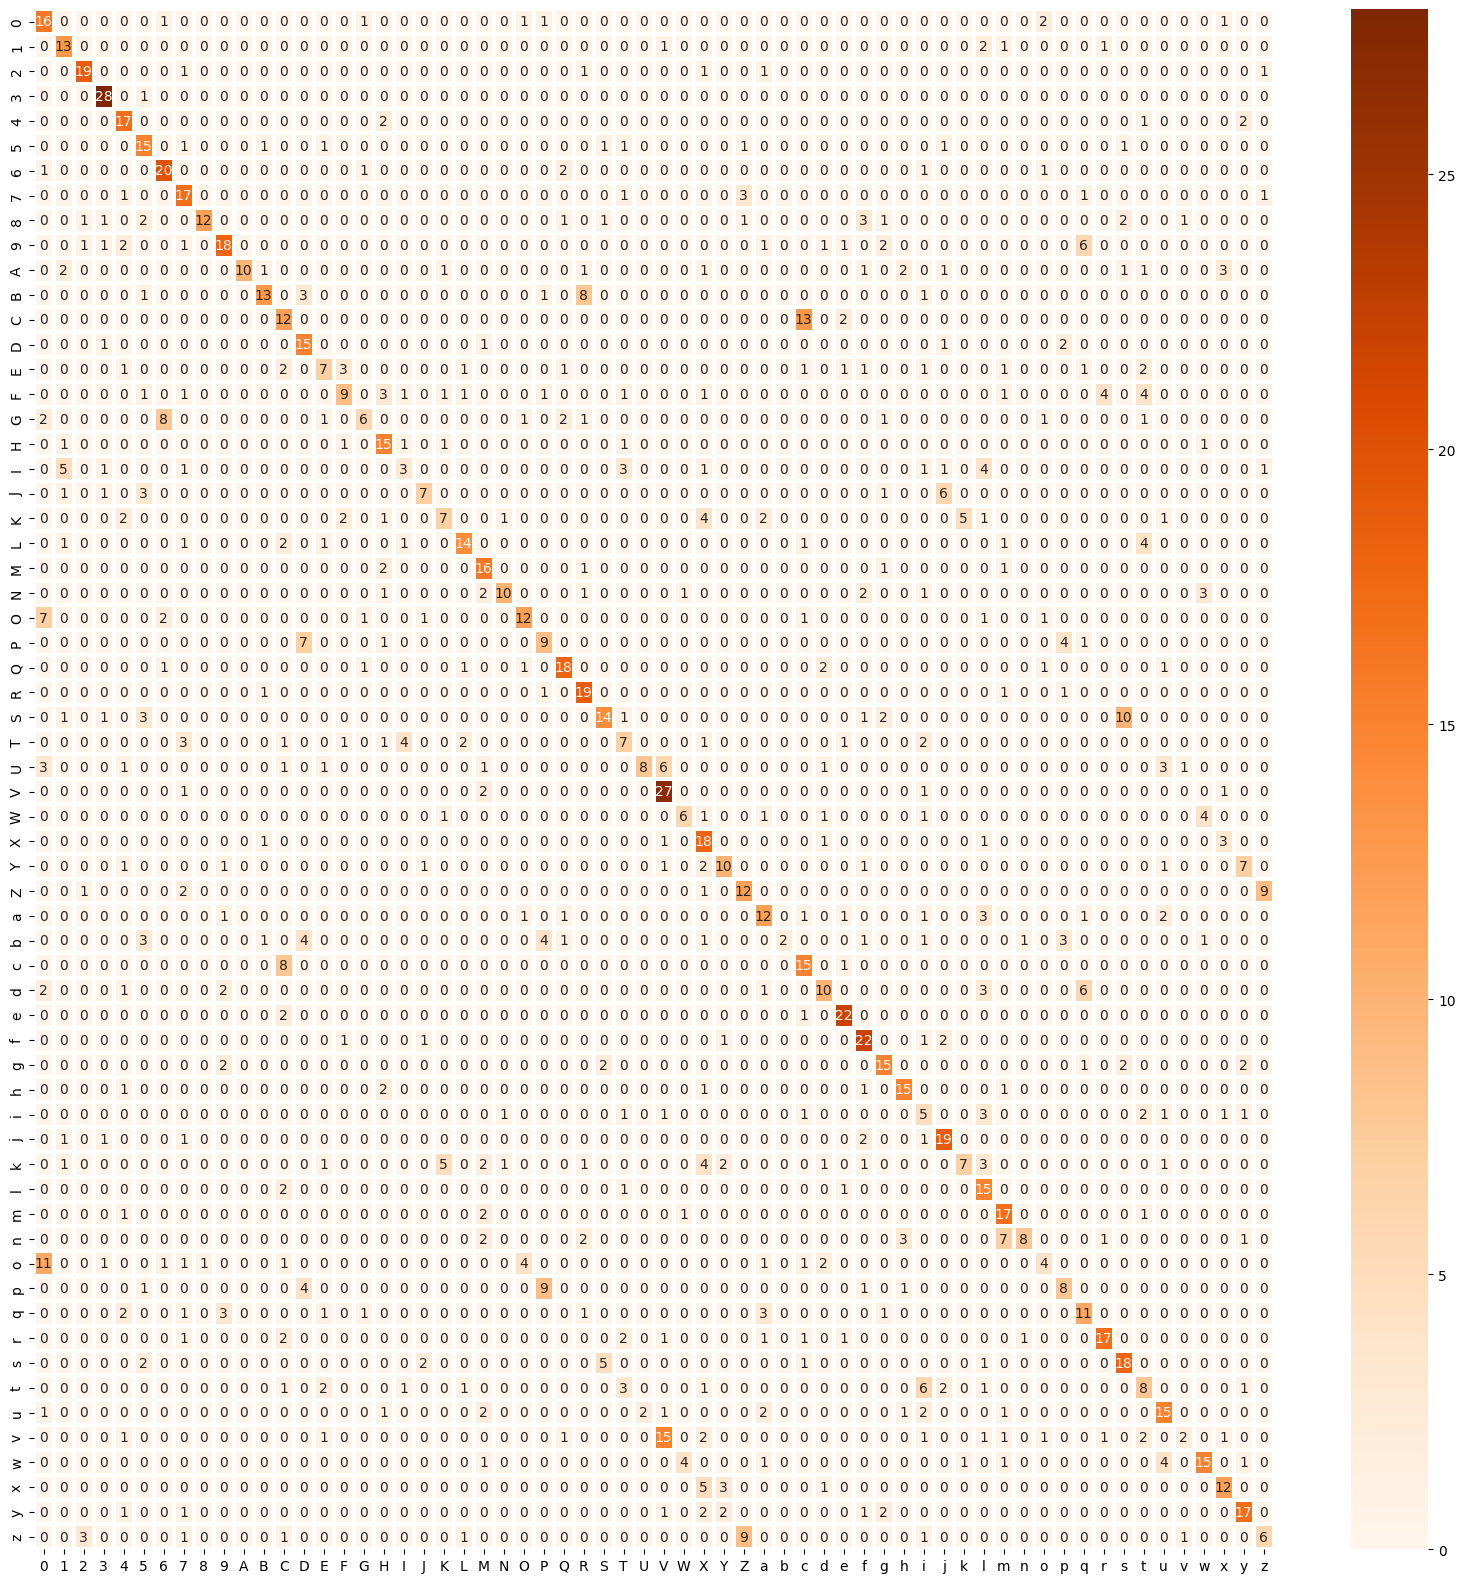

In [16]:
if __name__ == "__main__":
    cm=metrics.confusion_matrix(_targets,_preds)
    df_cm = DataFrame(cm, index=classes_names["val"], columns=classes_names["val"])
    from pandas import DataFrame
    import seaborn as sn
    plt.subplots(figsize=(20,20))
    sn.heatmap(df_cm,annot=True, fmt="d",linewidths=1.5,cmap="Oranges",)
    plt.savefig("images/CNNCell_uji_confusion_matrix.png",  bbox_inches='tight', pad_inches=0)
    plt.show()